
# Data Preparation Overview

This document describes the preparation of data used to support the development and evaluation of algorithms for retrieving and labeling API documentation pages. The process includes collecting raw HTML documents, labeling relevant pages as endpoint-related, and storing all data in a structured format for later use.


## Data Collection Objectives

The data in our case consists of raw HTML pages from multiple API documentation websites. Based on the HTML document—referred to here as an **API page** we need to perform two tasks. To better understand the tasks, we introduce one more distinction: the set of **API pages** contains the **endpoint pages** (API pages that actually contain the endpoints that need to be implemented) and their complement **non-endpoint pages**, which we are not interested in. Note here that there are also non-endpoint pages that contain general information about the API, which might be required to properly generate the endpoints, but that will be covered later during development.


## Tasks

Two main tasks in the project are defined as:
 1. Given the website link, parse the website and retrieve all API pages
 2. Using the API pages, generate the python code to interact with endpoints.

The data preparation aims to make both these task easier during development by providing structured data infrastructure that will ensure more modular development and save time allowing to interact with application parts relying on other parts.

## Benchmark Construction

The website parsing requires not only saving the pages but also an algorithm that will ensure all the endpoints are collected without too many additional irrelevant pages, which we will need to design ourselves.

For the algorithm design we decided to construct a benchmark, across which we can compare multiple algorithms on their performance.
From the list of APIs we constructed the labeled dataset, for each site we have created the binary classification labeling of the **Endpoint pages**.

Example object:
```json
[
      {
          "name": "aNewSpring",
          "base_url": "https://support.anewspring.com",
          "domain_url": "/en/",
          "endpoint_pages" :
                [
                    "https://support.anewspring.com/en/articles/70415-api-calls-users",
                    "https://support.anewspring.com/en/articles/70416-api-calls-user-groups",
                    "https://support.anewspring.com/en/articles/70417-api-calls-subenvironments",
                    "https://support.anewspring.com/en/articles/70418-api-calls-subscriptions",
                    "https://support.anewspring.com/en/articles/70407-api-calls-templates-and-courses",
                    "https://support.anewspring.com/en/articles/70626-api-calls-bundles",
                    "https://support.anewspring.com/en/articles/70419-api-calls-calendar-items",
                    "https://support.anewspring.com/en/articles/70420-api-calls-access-codes",
                    "https://support.anewspring.com/en/articles/70421-api-calls-events",
                    "https://support.anewspring.com/en/articles/70588-api-calls-profile"
                ]
      }
]
```

However the webparsing process is time-consuming and this is suboptimal to wait each time to evaluate algorithm, so we created a database for caching the HTML of the pages in the benchmark. So such approach allows for both running the `scraper_benchmark` function to evaluate scraping algorithms way faster (comparison in the next section), and retrieving the all HTML **endpoint pages** to test the code generation of the project, without need to rerun scraping. This will allow to us to iterate over the code generation method from the start of the project with the assumption that optimal scraping logic is already developed.
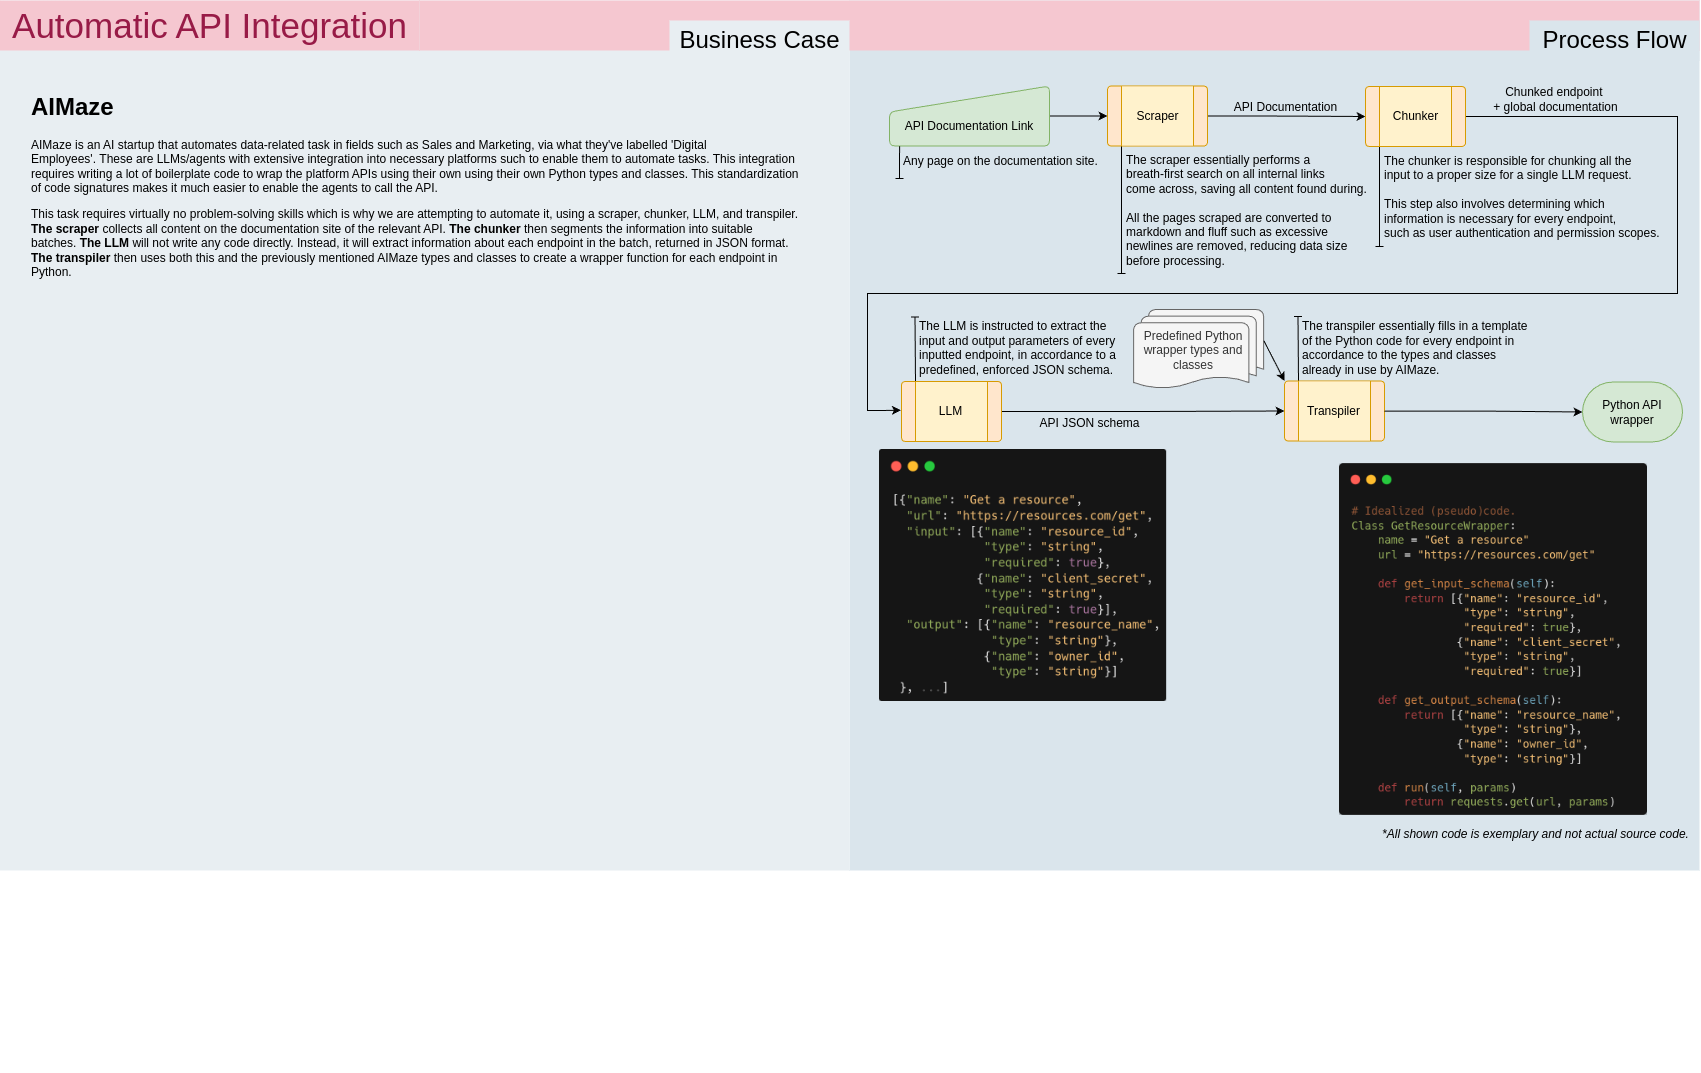
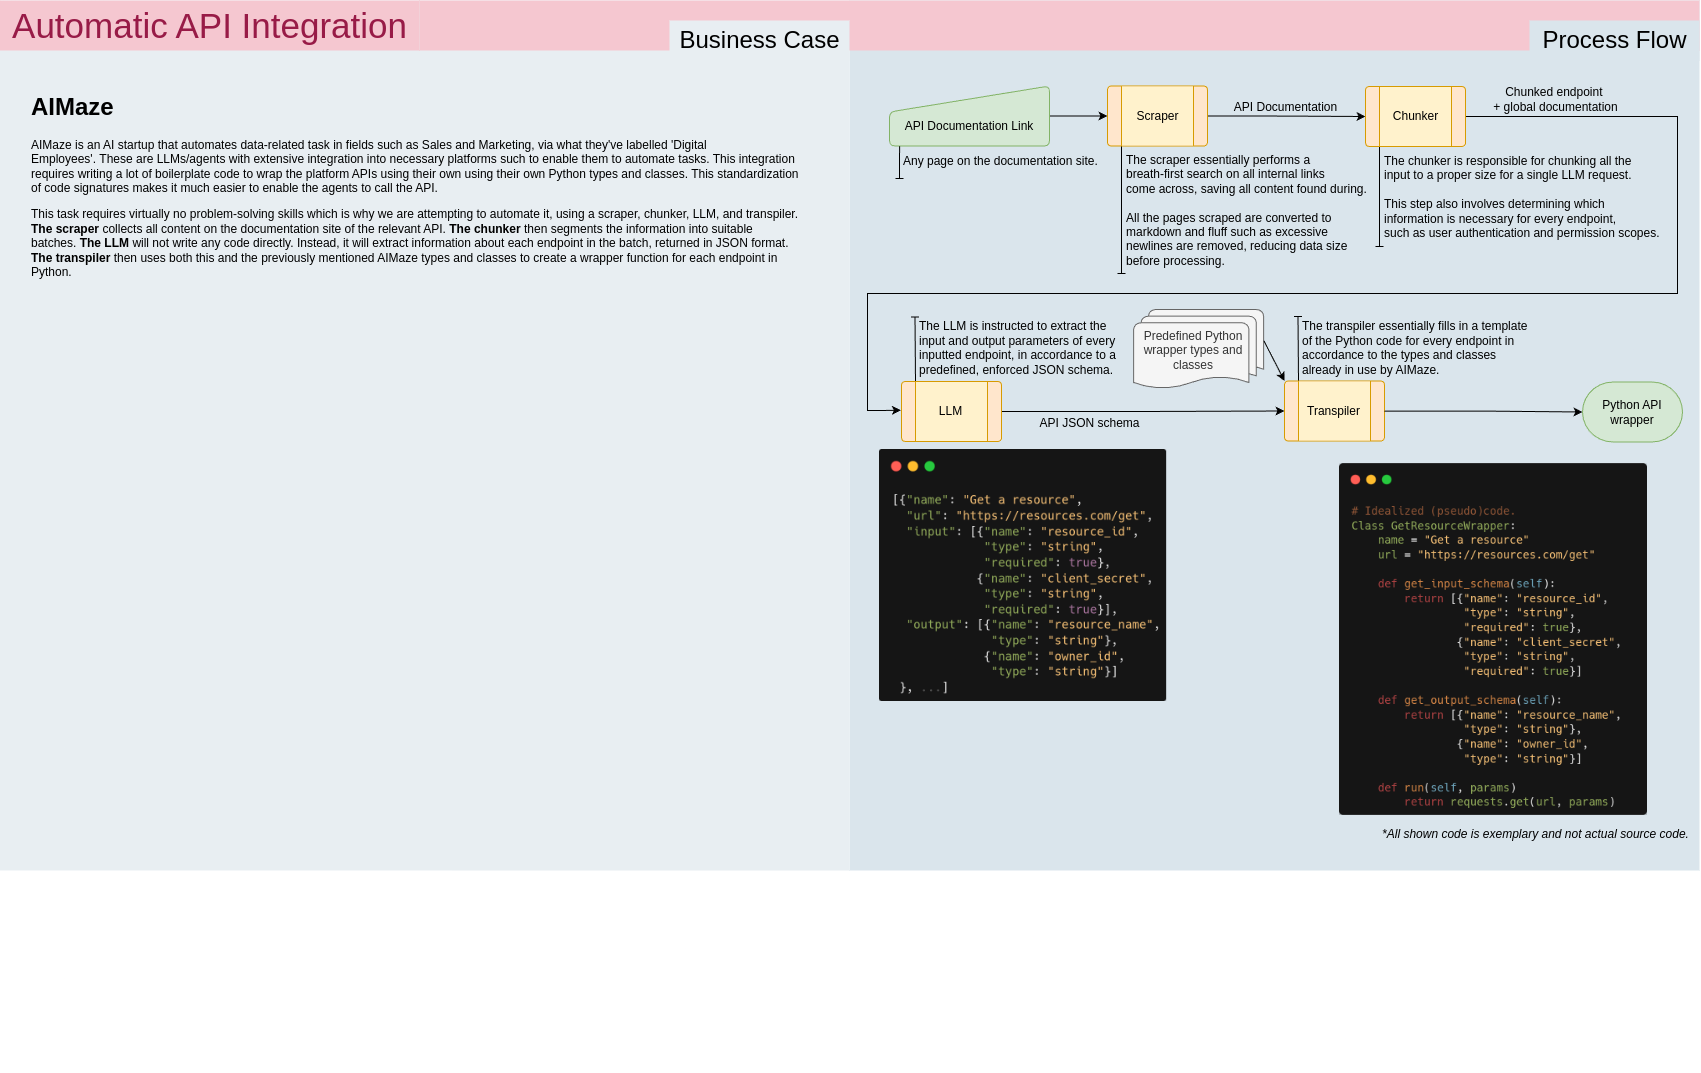


## Database Schema

To support modular and repeatable development, all scraped pages and their labels are stored in a local database. The table structure is as follows:

| Column | Type | Description|
|------|-----|----------------------------------------------|
| `url`| TEXT| Primary key. Full URL of the scraped page|
| `html`| TEXT| Raw HTML content of the page|
| `is_endpoint`| BOOLEAN| Whether the page is an endpoint page|


These functions are defined in the `db_utils`, here I have duplicated them to show in this notebook.

In [ ]:
import json
from src.scraper.scraper import bfs_site
from src.scraper.eval_db.db_utils import get_connection


def init_db():
    conn = get_connection()
    cur = conn.cursor()
    cur.execute('''
        create table if not exists pages (
            url TEXT primary key,
            html TEXT,
            is_endpoint BOOLEAN)
    ''')
    conn.commit()
    cur.close()
    conn.close()

def get_page_by_url(url:str) -> str:
    conn = get_connection()
    cur = conn.cursor()
    cur.execute("SELECT html FROM pages WHERE url = %s", (url,))
    row = cur.fetchone()
    cur.close()
    conn.close()
    return row[0] if row else None

def get_api_pages_by_url(url: str) -> list:
    conn = get_connection()
    cur = conn.cursor()
    cur.execute("SELECT html FROM pages WHERE url LIKE %s and is_endpoint = True", (f"%{url}%",))
    rows = cur.fetchall()
    cur.close()
    conn.close()
    return rows

def is_site_in_db(url: str) -> bool:
    conn = get_connection()
    cur = conn.cursor()
    cur.execute("SELECT 1 FROM pages WHERE url LIKE %s LIMIT 1", (f"%{url}%",))
    exists = cur.fetchone() is not None
    cur.close()
    conn.close()
    return exists

def store_page(url: str, html: str, is_endpoint: bool) -> None:
    conn = get_connection()
    cur = conn.cursor()
    cur.execute('''
        INSERT INTO pages (url, html, is_endpoint)
        VALUES (%s, %s, %s)
        on conflict do nothing
    ''', (url, html, is_endpoint))
    conn.commit()
    cur.close()
    conn.close()

def add_api_to_db(url: str, domain_url: str) -> None:

    with open('../benchmark_data.json', 'r') as file:
        data = json.load(file)
        for obj in data:
            if obj.get("base_url") == url:
                endpoint_pages = obj.get("endpoint_pages")


    data = bfs_site(url, lambda content: True, domain_url)

    all_scraped_pages = data.get("endpoint_pages", {})

    for key, value in all_scraped_pages.items():
        is_endpoint = key in endpoint_pages
        store_page(key, value, is_endpoint)

## Workflow and Labeling Logic

1. The benchmark JSON file is loaded.
2. The scraper executes a breadth-first search on each encountered (internal) link, starting from the `base_url`.
3. All reachable pages are saved with their HTML content.
4. Each page is checked against the benchmark `endpoint_pages`. If it is found there, it is labeled as `is_endpoint = True`.
5. The complete set of pages and labels is stored in the database.

In the `add_api_to_db` function we have the `bfs_site` function, since we want to parse all the pages from the website and save them to the DB, we pass:

```python
lambda content: True
```

That filters and adds all the pages to the result.

This database serves as a mimic of the internet, with small adjustment to the `bfs_site` function we now could retrieve the HTML from database by link using `get_page_by_url` and then use `beautifulsoup` library to work with the HTML just like it was received from the web request.

## Time Comparison

Here we evaluate both versions to show the time difference between running the web parsing and DB mimic.

In [2]:
import time
from src.scraper.scraper_benchmark import benchmark_scraper

# Time live scraping
start_live = time.perf_counter()
benchmark_scraper(lambda content: True, num_apis=1, use_db=False, log=False)
end_live = time.perf_counter()
live_duration = end_live - start_live
print(f"Live scraping took {live_duration:.2f} seconds")

# Time database version
start_db = time.perf_counter()
benchmark_scraper(lambda content: True, num_apis=1, use_db=True, log=False)
end_db = time.perf_counter()
db_duration = end_db - start_db
print(f"Database access took {db_duration:.2f} seconds")

2025-04-18 13:28:40.511 | INFO     | src.scraper.scraper_benchmark:benchmark_scraper:75 - Benchmarking API: aNewSpring (https://support.anewspring.com)
2025-04-18 13:49:50.613 | INFO     | src.scraper.scraper_benchmark:benchmark_scraper:98 - API aNewSpring: Expected 10, Scraped 596, Matched 10, Coverage 100.00%
2025-04-18 13:49:50.620 | INFO     | src.scraper.scraper_benchmark:benchmark_scraper:119 - Benchmark completed. Summary written to benchmark_summary.json
2025-04-18 13:49:50.660 | INFO     | src.scraper.scraper_benchmark:benchmark_scraper:75 - Benchmarking API: aNewSpring (https://support.anewspring.com)


Live scraping took 1270.20 seconds


2025-04-18 13:50:22.819 | INFO     | src.scraper.scraper_benchmark:benchmark_scraper:98 - API aNewSpring: Expected 10, Scraped 596, Matched 10, Coverage 100.00%
2025-04-18 13:50:22.823 | INFO     | src.scraper.scraper_benchmark:benchmark_scraper:119 - Benchmark completed. Summary written to benchmark_summary.json


Database access took 32.17 seconds


In [3]:
speedup_factor = live_duration / db_duration if db_duration else float('inf')

print("\n--- Benchmark Comparison ---")
print(f"Live scraping: {live_duration:.2f} seconds")
print(f"Database use : {db_duration:.2f} seconds")
print(f"Speedup      : {speedup_factor:.2f}× faster")


--- Benchmark Comparison ---
Live scraping: 1270.20 seconds
Database use : 32.17 seconds
Speedup      : 39.48× faster


As observed from the comparison, the difference in time is dramatic, suggesting that using DB is crucial to ensure efficient development.

The result of the benchmark is saved and stored in separate file, for this run:

```json
{
    "overall": {
        "total_expected": 10,
        "total_scraped": 596,
        "total_matched": 10,
        "overall_coverage": 1.0
    },
    "apis": {
        "aNewSpring": {
            "expected": 10,
            "scraped": 596,
            "matched": 10,
            "coverage": 1.0,
            "missing": [],
            "extra": [
                "https://support.anewspring.com/en/articles/45857-play-content-from-another-system-in-anewspring-using-lti-1-1-consumer",
                "https://support.anewspring.com/en/articles/70600-questions-fill-in-the-blanks-text-content-converter",
                "...",
                "https://support.anewspring.com/en/articles/32177-set-up-a-hand-in-assignment",
                "https://support.anewspring.com/en/articles/70435"
            ]
        }
    }
}
```

## Code Generation
With the data preparation and storage infrastructure in place, the development of the coder component becomes fully decoupled from the web scraping and parsing logic. The benefits this offers have already been mentioned (less interdependency, faster development/iteration, preventing 'leaking' scopes) above.

## Conclusion

With the data preparation and storage infrastructure in place, the development of the coder component becomes fully decoupled from the web scraping and parsing logic. The benefits this offers have already been mentioned (less interdependency, faster development/iteration, preventing 'leaking' scopes) above.

This data preparation process provided a robust foundation for modular development, benchmarking, and experimentation across different components of the application. By separating concerns between data acquisition, labeling, and downstream usage, we achieved several key benefits:

- **Reusability and Modularity**: Once pages are scraped and stored, they can be reused across multiple phases—benchmarking, endpoint classification, and code generation—without re-crawling the source websites. This allows developers to work independently on different parts of the system.

- **Benchmarking Support**: The labeled dataset of known endpoint pages enables objective evaluation of different crawling strategies. By comparing parsed output against the benchmark, we can iteratively improve scraping algorithms with measurable feedback.

- **Fast Iteration**: The database acts as a local mirror of the documentation sites. This allows for rapid testing of filters, heuristics, and extraction techniques without repeated network requests, significantly speeding up development.

- **Seamless and Decoupled Integration for Code Generation**: With endpoint pages readily available in the database, the code generation module can be developed and tested independently of the scraper. This decouples the system and ensures that early work on code generation is not blocked by scraping performance. This also prevents 'leaky' scopes where one can stray off course and spend much time tweaking the scraper while intending to work on the code generation.


In short, this data preparation step transforms an inherently messy and variable process—web crawling and API documentation analysis—into a structured, testable, and iterative workflow. It enables the project to be developed as a pipeline of loosely coupled modules, each of which can be tested, benchmarked, and improved in isolation.
